<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DEPENDENCIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import ResNet50V2
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
#HYPERPARAMETER

EPOCHS = 3
LOSS = CategoricalCrossentropy()
OPTIMIZERS = Adam()
input_shape = (224,224,3)
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"

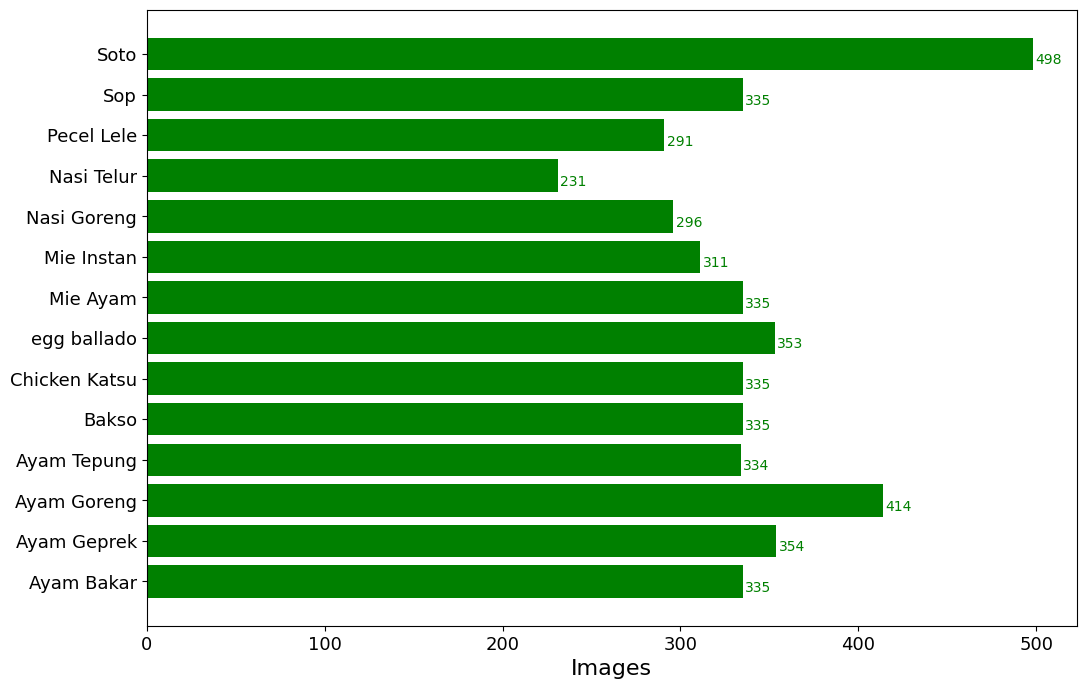

In [3]:
data=dict()

for i in os.listdir(train_dir):
    sub_dir=os.path.join(train_dir,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Labeling Photo Using ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Show All Classes

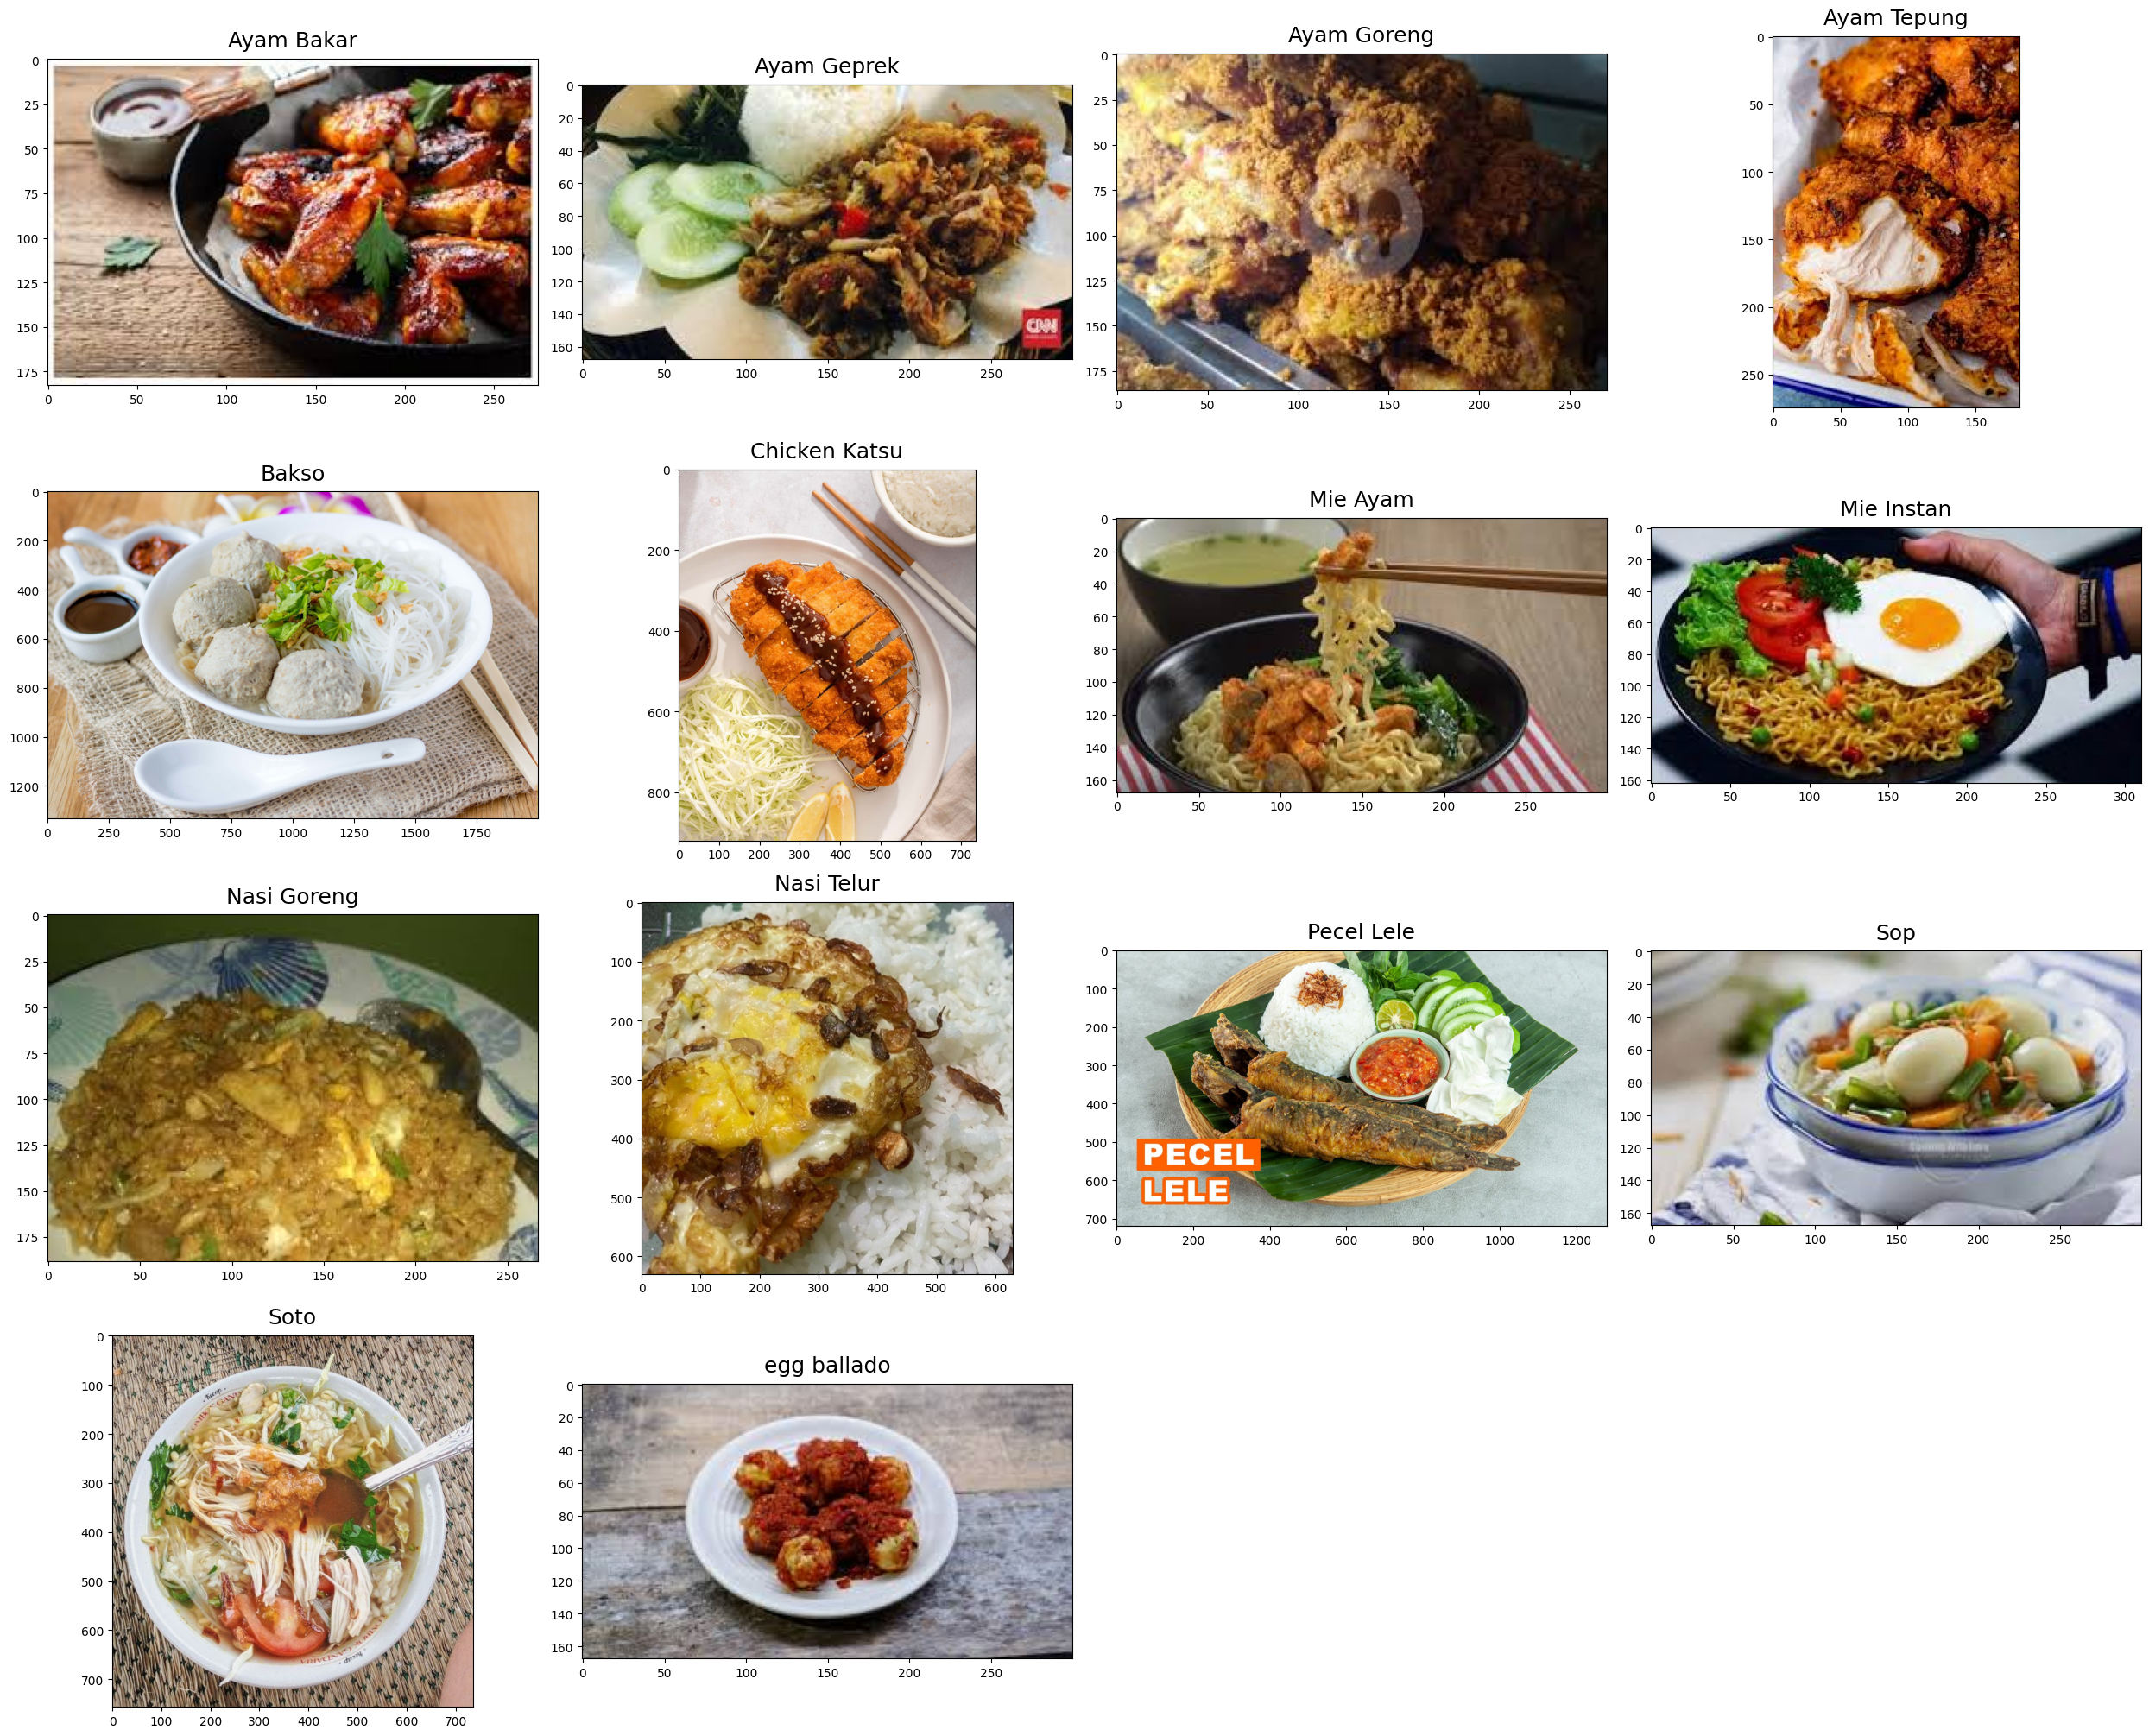

In [5]:
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 4751 images belonging to 14 classes.
Found 976 images belonging to 14 classes.


Making Callbacks for Training

In [7]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
)

In [8]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

for layer in resnet.layers[:145]:
    layer.trainable = False

for layer in resnet.layers[145:]:
    layer.trainable=True

Making Model

In [9]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(14,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 14)                910       
                                                                 
Total params: 24647630 (94.02 MB)
Trainable params: 16907726 (64.50 MB)
Non-trainable params: 7739904 (29.53 MB)
_________

In [11]:
# model.load_weights('Weights/weight')
model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_generator,epochs=3,validation_data=test_generator,callbacks=[model_checkpoint_callback])

Epoch 1/3
476/476 [==============================] - 1193s 2s/step - loss: 1.2796 - accuracy: 0.5740 - val_loss: 0.9567 - val_accuracy: 0.6998
Epoch 2/3
146/476 [========>.....................] - ETA: 12:07 - loss: 0.9763 - accuracy: 0.6884

KeyboardInterrupt: 

In [ ]:
model.save_weights('Weights/weight')

RESULTS

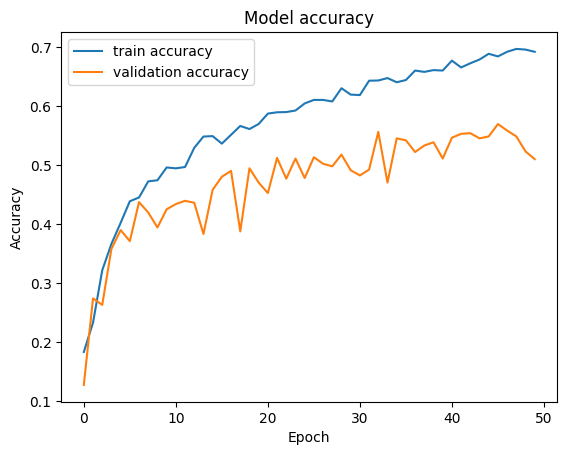

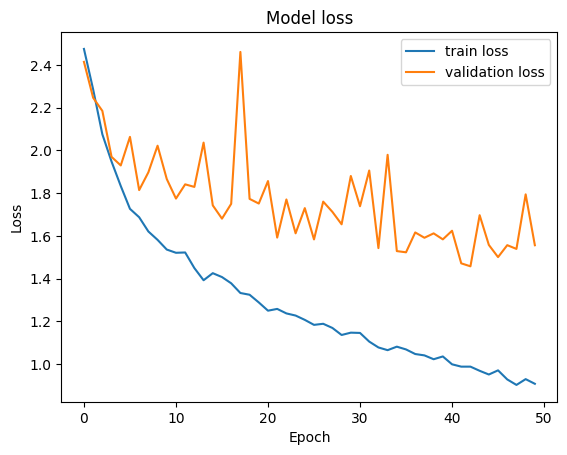

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [ ]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

454/454 [==============================] - 9s 20ms/step


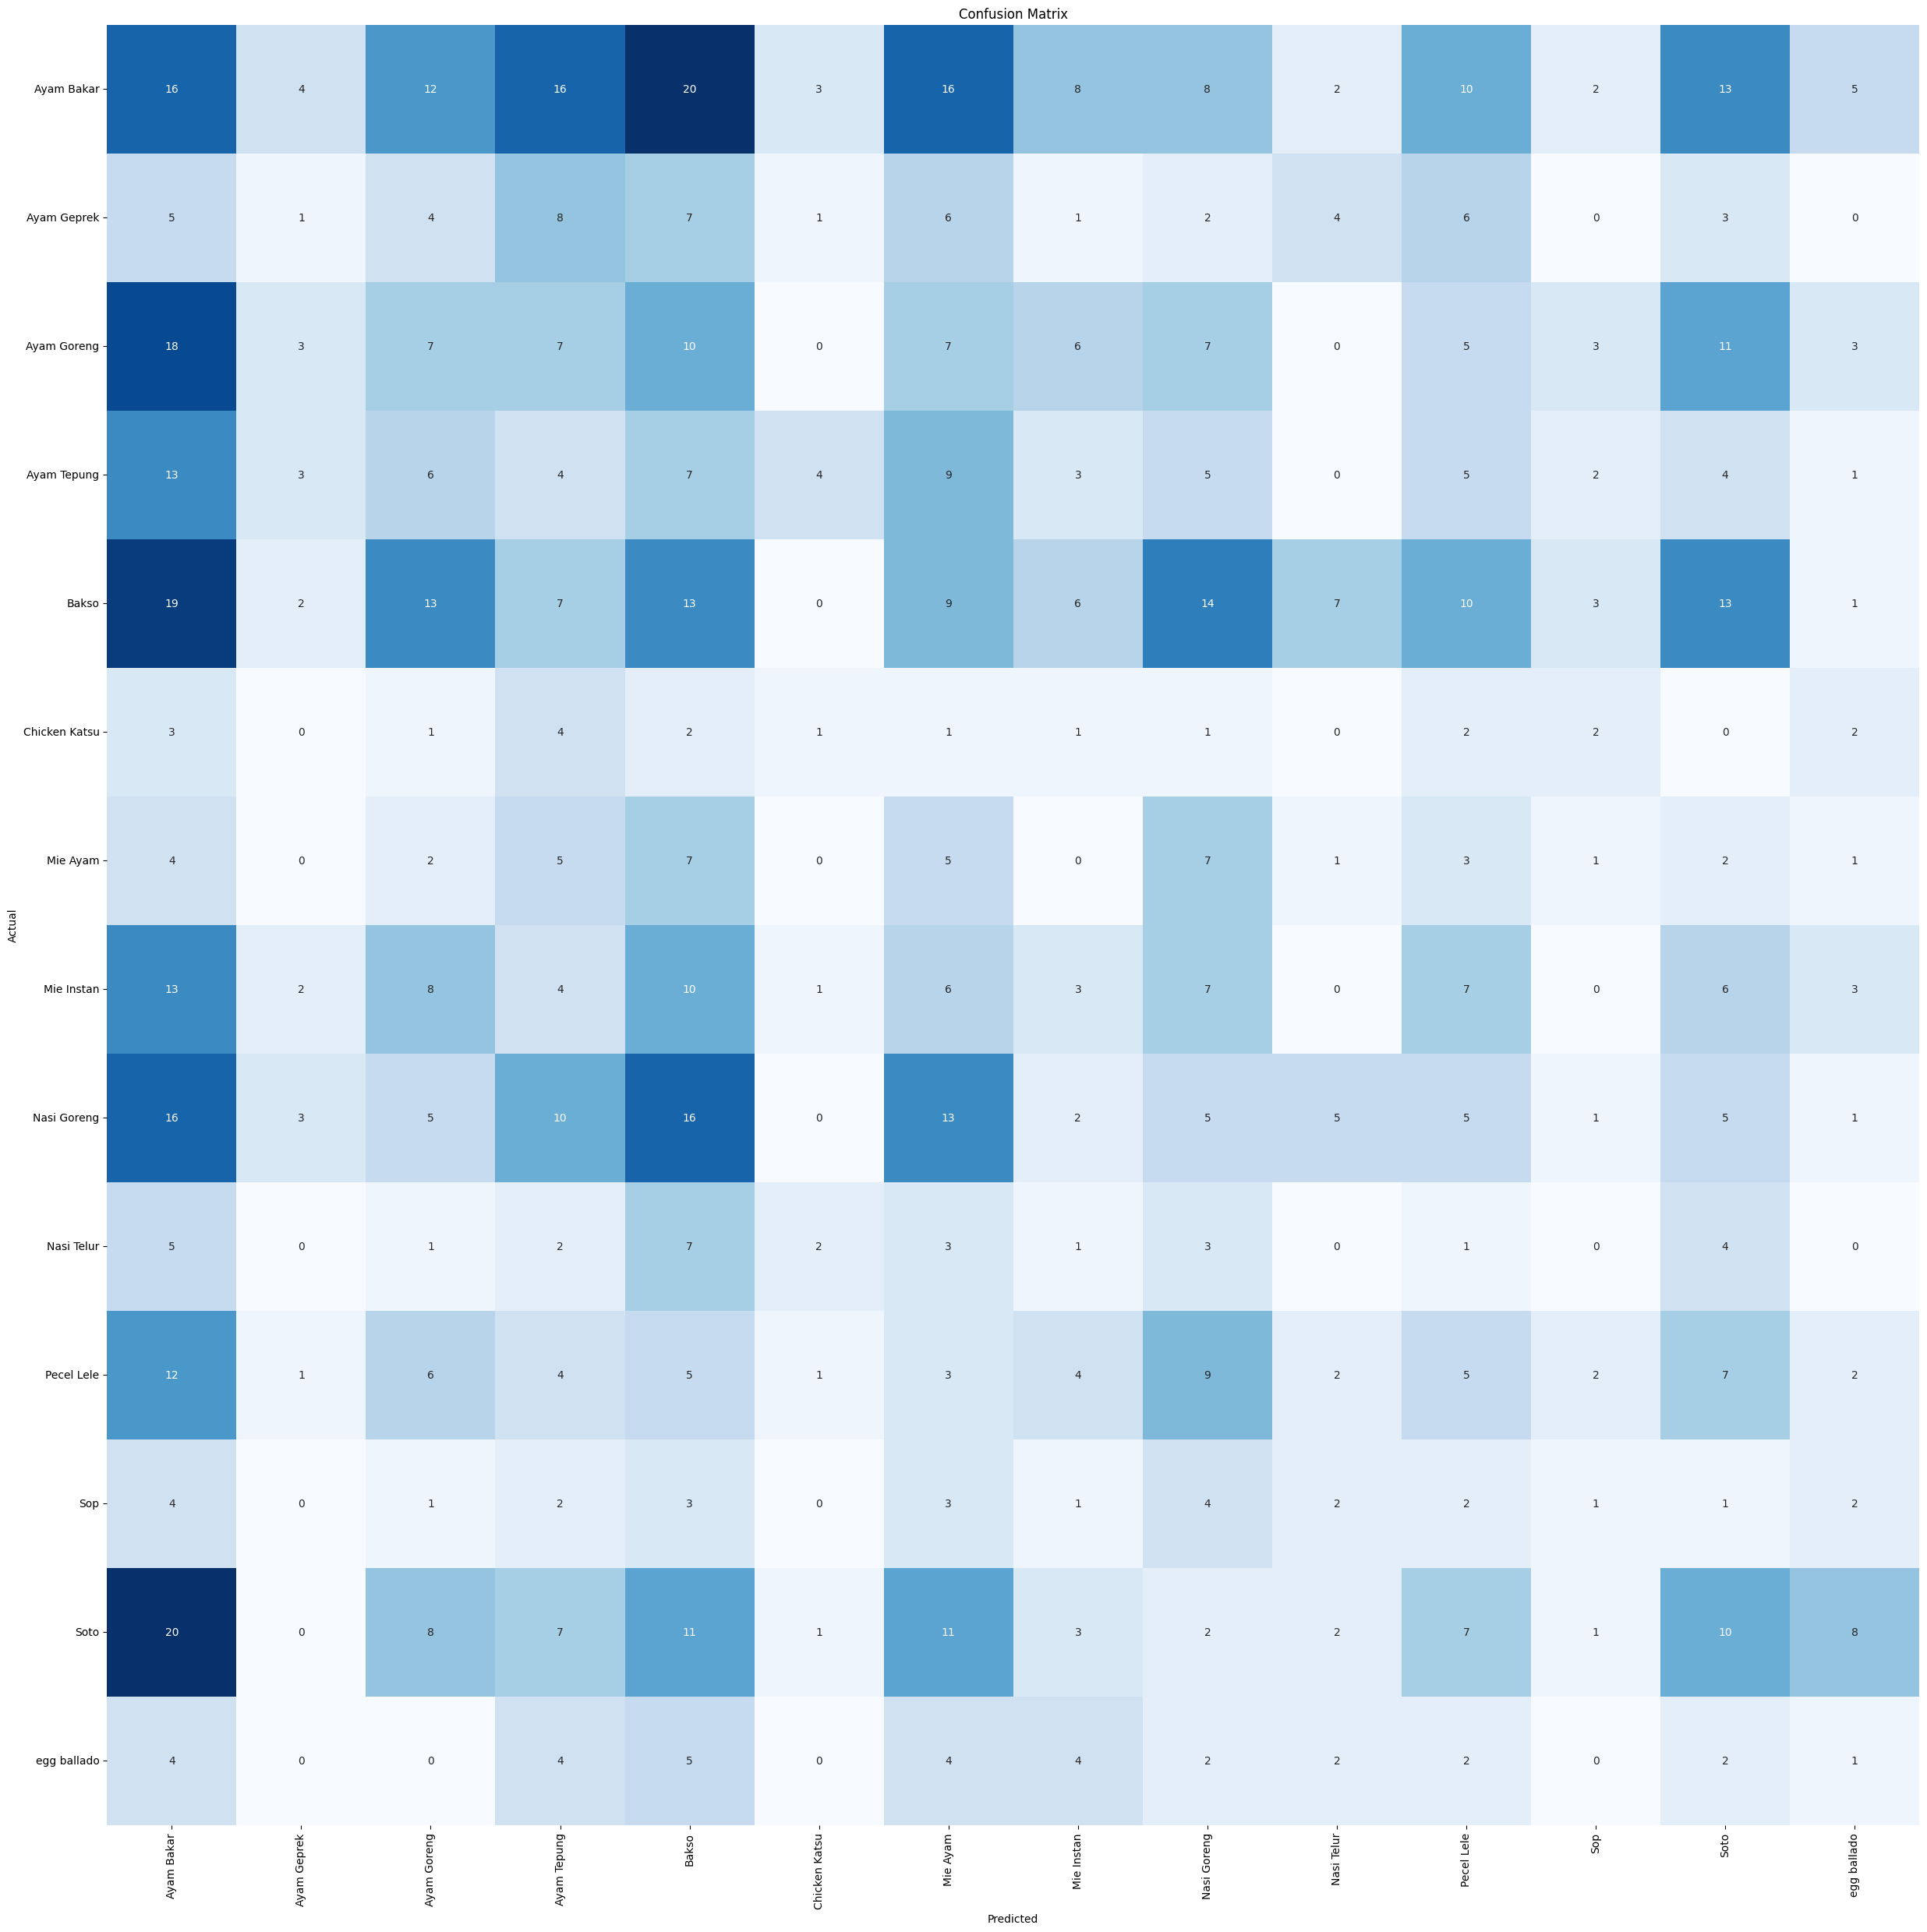

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.11      0.12      0.11       135
  Ayam Geprek       0.05      0.02      0.03        48
  Ayam Goreng       0.09      0.08      0.09        87
  Ayam Tepung       0.05      0.06      0.05        66
        Bakso       0.11      0.11      0.11       117
Chicken Katsu       0.07      0.05      0.06        20
     Mie Ayam       0.05      0.13      0.07        38
   Mie Instan       0.07      0.04      0.05        70
  Nasi Goreng       0.07      0.06      0.06        87
   Nasi Telur       0.00      0.00      0.00        29
   Pecel Lele       0.07      0.08      0.08        63
          Sop       0.06      0.04      0.05        26
         Soto       0.12      0.11      0.12        91
  egg ballado       0.03      0.03      0.03        30

     accuracy                           0.08       907
    macro avg       0.07      0.07      0.06       907
 weighted avg   